# Constrained sampling with QeMCMC

This notebook is designed not to show the reader how to use this package, but to explain the concept of sampling from constrained spaces with QeMCMC.

We first analyse the dispersion of classical MCMC proposals, and study how and why QeMCMC moves might offer speedup. 


## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from helpers import *
from Sampler import Sampler
from tqdm import tqdm


/mnt/c/Users/Stuart Ferguson/OneDrive - University of Edinburgh/Documents/PhD/CODE/CST/SamplingCausalSets/SamplingCausalSets/.venv/lib/python3.13/site-packages/numpy/_core/getlimits.py:552: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


## Analysis function

You may safely ignore the following code block. It runs and plots the outcome of many proposals for a given sampler, so that they may be analysed to understand the behaviour of the sampler.

In [ ]:

def analyse_output_bitstrings(sampler, repeats = 100, title = "Transition Matrix", plot_grid = False, plot_cumulative = False):
    """
    Analyzes the output bitstrings generated by a sampler and computes various metrics 
    related to transition probabilities, BD transitions, and forbidden/self transitions. 
    Optionally, it visualizes the transition matrix and cumulative probability distributions.
    Parameters:
    -----------
    sampler : object
        The sampler object that generates proposals and contains relevant parameters 
        such as `n` (number of nodes) and `q` (number of bits in the bitstring).
    repeats : int, optional
        The number of times to repeat the sampling process for each configuration. 
        Default is 100.
    title : str, optional
        The title for the transition matrix plot. Default is "Transition Matrix".
    plot_grid : bool, optional
        If True, displays the transition matrix plot. If False, the plot is closed. 
        Default is False.
    plot_cumulative : bool, optional
        If True, displays the cumulative probability histogram. If False, the plot is closed. 
        Default is False.
    Returns:
    --------
    weighted_BD_transitions_ignoring_self_transitions : numpy.ndarray
        A flattened array of weighted BD transitions, excluding self-transitions, 
        used for cumulative probability analysis.
    Notes:
    ------
    - The function computes the transition matrix, BD action differences, and 
        forbidden/self transition frequencies.
    - The function supports visualization of the transition matrix and cumulative 
        probability distributions.
    - Forbidden transitions are transitions to configurations that are not valid 
        causal matrices.
    - Self-transitions are transitions where the initial and proposed configurations 
        are the same.
    """
    
    if repeats ==1:
        raise ValueError("Repeats must be greater than 1")
    
    # Generate all of the possibl causal matrices for cardinality n
    _, unique_causal_matrix = get_unique_matrices(sampler.n)
    
    
    # Generate the binary matrix
    mats = [np.frombuffer(mat, dtype=np.int32).reshape( sampler.n,  sampler.n) for mat in  unique_causal_matrix]
    
    print(" ")
    print("Number of unique causal matrices: ", len(mats))
    
    # For each matrix, generate a bitstring
    labels = ["".join(str(i) for i in mat[np.triu_indices( sampler.n, 1)]) for mat in mats]
    
    # Create an array that hold the number of proposals from each causal matrix to each other matrix
    proposal_tracker = np.zeros((2** sampler.q,2** sampler.q))
    
    # Create an array that holds the BD action values for each causal matrix
    BD_action = np.zeros(2** sampler.q)
    
    # Loop through each causal matrix, and create example proposals. 
    # This gives an indication of what binary matrices are proposed from each causal matrix
    for s_pos, s in tqdm(enumerate(labels)):
        
        
        s_prime_list =  sampler.proposal(s, multiple = repeats)
        s_int = int(s, 2)
        
        for s_prime in s_prime_list:
            s_prime_int = int(s_prime, 2)
            proposal_tracker[s_int, s_prime_int] += 1


        BD_action[s_int] =  calculate_action(mats[s_pos])
    
    
    
    BD_sorted_args = np.argsort(BD_action)
    sorted_BD = BD_action[BD_sorted_args]
    # Sort the proposal tracker according to BD action,
    proposal_tracker = proposal_tracker[BD_sorted_args,:]
    proposal_tracker = proposal_tracker[:,BD_sorted_args]
    
    #reorder and normalise
    _proposal_tracker = np.flipud(proposal_tracker)/repeats
    

    cmap = colors.LinearSegmentedColormap.from_list('red_white', ['white', 'red'], N=256)
    
    
    non_zero_bd_index = np.where(sorted_BD != 0)[0][0]
    plt.xticks([])
    plt.yticks([])
    plt.ylim(non_zero_bd_index, 2** sampler.q)
    plt.imshow(_proposal_tracker, extent=[0, 2**sampler.q, 0, 2**sampler.q], cmap=cmap, interpolation='nearest', norm=colors.LogNorm(vmin=1/(2*repeats), vmax=1))
    plt.colorbar(label='Transition Probability', norm=colors.LogNorm(vmin=1/repeats, vmax=1))
    plt.xlabel('Proposed Configuration (s\')')
    plt.ylabel('Initial Configuration (s)')
    plt.title(title)
    
    
    s_int_list = [int(s, 2) for s in labels]
    all_ints = np.arange(0, 2** sampler.q)
    

    all_ints = all_ints[BD_sorted_args]
    
    plt.plot([non_zero_bd_index, 2** sampler.q], [non_zero_bd_index,non_zero_bd_index] ,color='blue', linestyle='--', label='Non-zero BD')
    plt.plot([non_zero_bd_index,non_zero_bd_index], [non_zero_bd_index, 2**sampler.q] ,color='blue', linestyle='--', label='Non-zero BD')


    
    forbidden_count = 0
    for s_pos, s_int in enumerate(all_ints):
        if s_int not in s_int_list:
            for pos_i, i in enumerate(all_ints):
                if proposal_tracker[pos_i, s_pos] > 0:
                    forbidden_count += proposal_tracker[pos_i, s_pos]

            
    print(" ")
    print(" --------------------- ")
    print(title)
    BD_transitions = np.zeros((2** sampler.q,2** sampler.q))
    for i in range(2** sampler.q):
        for j in range(2** sampler.q):
            BD_transitions[i,j] = np.abs(sorted_BD[i] - sorted_BD[j])
    
    total_bd_transition_cost = np.sum((BD_transitions[non_zero_bd_index:,non_zero_bd_index:] * proposal_tracker[non_zero_bd_index:,non_zero_bd_index:]))
    
    total_transitions = np.sum(proposal_tracker)
    
    self_transitions = np.sum(np.diag(proposal_tracker))
    
    print(" ")
    print("Average BD transition cost: ", total_bd_transition_cost/(total_transitions-forbidden_count-self_transitions))
    print(" ")
    print("Frequency of self transitions: ", self_transitions / total_transitions)
    print("Frequency of forbidden transitions: ", forbidden_count / total_transitions)
    
    if plot_grid:
        plt.show()
    else:
        plt.close()

    
    print(" --------------------- ")
    print(" ")
    
    return

    
    

## Inputs

In [47]:
# Cardinality of causal set that we are interested in
cardinality = 4

# Number of times to repeat the sampling process per input causal set
repeats = 1000

## Sampler object

The following code initialises a sampler object. Samplers can, depending on how they are initialised, run a classical or quantum sampling process. Of course, both should sample the same distribution, however if it is correctly initialised then the quantum method should sample more efficiently.

 * cardinality: The number of elements in the causal set
 * method: The sampling method to use, quantum or classical
 * dimension: The dimension of the BD action
 * cargs: The arguments required for classical sampling. A dictionary containing boolean values for keys "link_move" and "relation_move", corresponding to which classical move to choose (both can be true, in which case they atre both used with 50% chance at each sample.)

### Link move


cargs recieved :  {'link_move': True, 'relation_move': False}
------------------------------------------------------------
Starting classical algorithm with the following parameters:
Link move:  True
Relation move:  False
 
Number of unique causal matrices:  40


40it [00:05,  7.23it/s]


 
 --------------------- 
Link move
 
Average BD transition cost:  0.050467054250689335
 
Frequency of self transitions:  0.247475
Frequency of forbidden transitions:  0.0


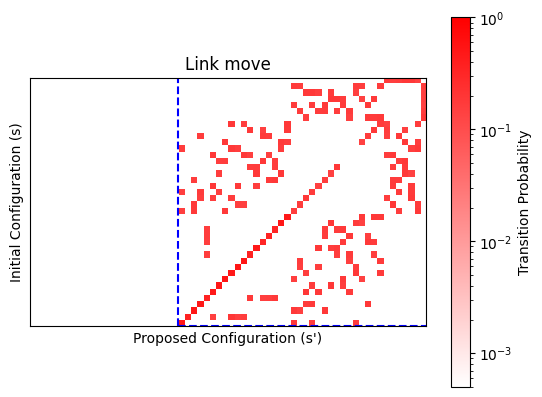

 --------------------- 
 


In [48]:

# Initialise a classical sampler, that uses only the link move
csamp = Sampler(cardinality, method="classical", dimension = 4, cargs = {"link_move":True, "relation_move": False})

# Plot the oucome of sampling
analyse_output_bitstrings(csamp, repeats = repeats, title =  "Link move", plot_grid = True, plot_cumulative = False)


The above code should plot a figure. On the y axis, is the initial configuration. Each point on the y axis corresponds to a particular causal set and it is ordered by the magnitude of each sets BD action. The x-axis includes not just causal sets, but also the space of binary matrices that are not causal sets, in other words, ones which break the constraint of transitive closure. 

Notice the white section on the left side of the graph, this indicates the space of binary matrices, that do not correspond to transitively closed causal matrices. Naturally, it is empty, as the classical link move can, by definition, only propose causal sets.


Also note that from each initial causal set, the link move can only propose a very finite number of other causal matrices. It can also fail to produce a proposal that is different from the current causal set, resulting in the filled diagonal.

### Relation move

One alternative to the link move, is the relation move. Both are discussed in detail in Henson 2016.

cargs recieved :  {'link_move': False, 'relation_move': True}
------------------------------------------------------------
Starting classical algorithm with the following parameters:
Link move:  False
Relation move:  True
 
Number of unique causal matrices:  40


40it [00:02, 14.91it/s]


 
 --------------------- 
Relation move
 
Average BD transition cost:  0.03517434577154961
 
Frequency of self transitions:  0.232875
Frequency of forbidden transitions:  0.0


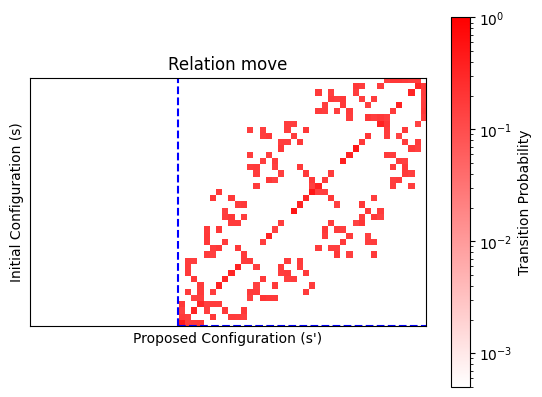

 --------------------- 
 


In [49]:

csamp = Sampler(cardinality, method="classical", dimension = 4, cargs = {"link_move":False, "relation_move": True})
analyse_output_bitstrings(csamp, repeats = repeats, title = "Relation move", plot_grid = True, plot_cumulative = False)



Again, the relation move can make a discrete set of moves, none of which result in non-causal sets

In practise, using both together results in the most efficient sampler. This is likely due to the larger space of moves that the combined method is able to make.

cargs recieved :  {'link_move': True, 'relation_move': True}
------------------------------------------------------------
Starting classical algorithm with the following parameters:
Link move:  True
Relation move:  True
 
Number of unique causal matrices:  40


40it [00:04,  8.77it/s]


 
 --------------------- 
Both classical moves
 
Average BD transition cost:  0.042577217861618624
 
Frequency of self transitions:  0.24195
Frequency of forbidden transitions:  0.0


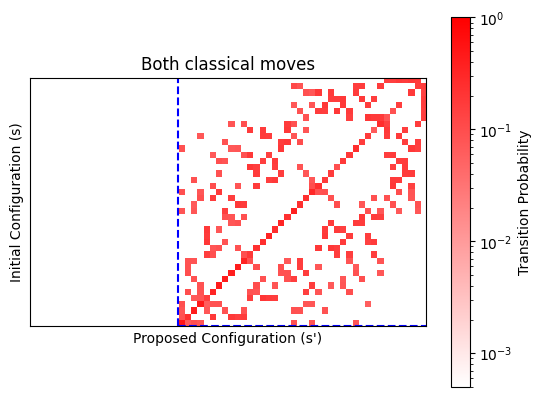

 --------------------- 
 


In [52]:
csamp = Sampler(cardinality, method="classical", dimension = 4, cargs = {"link_move":True, "relation_move": True})
analyse_output_bitstrings(csamp, repeats = repeats, title = "Both classical moves", plot_grid = True, plot_cumulative = False)

# Quantum algorithm

The quantum algorithm, uses time evolution of a "mixing hamiltonian", to create a superposition of configurations. 

If once selects the "quantum" method, they must provide 

* qargs: Dict containing keys "t", "gammas" and optionally some other arguments
    * t: The time of quantum evolution
    * gammas: List representing the relative weight of different Hamiltonian components (see documentation for full details)
        All items in list must add to 1. The first item controls the constraint term, the second the energy (BD-action) term, and the last represents the strength of the mixing.




------------------------------------------------------------
Starting quantum algorithm with the following parameters:
gamma_TC:  0
gamma_BD:  0
gamma_mixing:  1
t:  20
 
Number of unique causal matrices:  40


40it [00:00, 177.97it/s]


 
 --------------------- 
Mixing only
 
Average BD transition cost:  0.07267876597392539
 
Frequency of self transitions:  0.0
Frequency of forbidden transitions:  0.418975


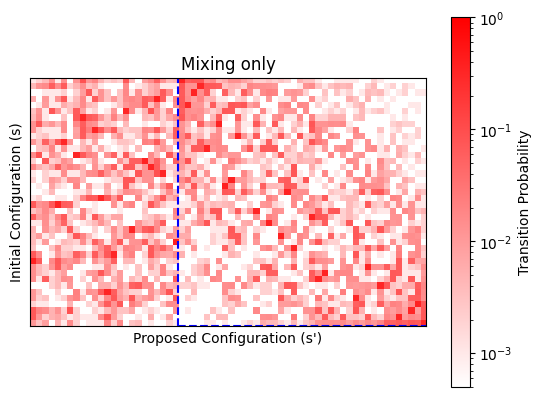

 --------------------- 
 


In [54]:
t = 20
Qsamp = Sampler(cardinality, method="quantum",dimension = 4, qargs = {"gammas":[0,0,1], "t":t})
analyse_output_bitstrings(Qsamp, repeats = repeats, title = "Mixing only", plot_grid = True, plot_cumulative = False)

By starting with initial causal sets, we can induce a superposition of every other causal set. Measuring this superposition results in proposals, across the space of causal sets. However, we also accidentally propose non-causal sets, meaning that we need to (classically) reject these.

## Constrained sampling

What if we could suppress these non-causal set configurations in the superposition? We can! Through the addition of a constraint term in the Hamiltonian, we can suppress non-causal sets. This can be done by suplying the value of gamma in the qargs dict to be [0.9,0,0.1].

------------------------------------------------------------
Starting quantum algorithm with the following parameters:
gamma_TC:  0.9
gamma_BD:  0
gamma_mixing:  0.1
t:  20
 
Number of unique causal matrices:  40


40it [00:00, 40.13it/s]


 
 --------------------- 
Mixing and TC
 
Average BD transition cost:  0.06637760948304249
 
Frequency of self transitions:  0.0036
Frequency of forbidden transitions:  0.009375


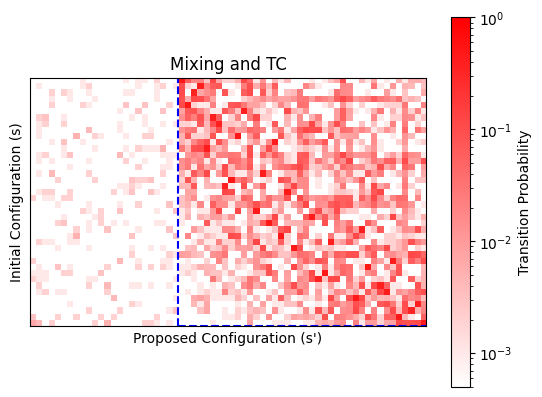

 --------------------- 
 


In [55]:
title = "Mixing and TC"
titles.append(title)
Qsamp = Sampler(cardinality, method="quantum",dimension = 4, qargs = {"gammas":[0.9, 0, 0.1], "t":t})
analyse_output_bitstrings(Qsamp, repeats = repeats, title = title, plot_grid = True, plot_cumulative = False)

Notice how very few proposals are non-causal sets (remember, non-causal sets are in the left hand section of the plot)

## Weighted sampling

When we want to do weighted sampling, it is very handy to be able to propose causal sets of similar BD action to the initial causal set. This would be evident in our plots as elements close to the diagonal being red (high probability) and those far from the diagonal being whiter. We can do this by adding the BD-action term.

Gamma ratios provided, setting gammas to: TC:  0.7 BD:  0.21000000000000002 Mixing:  0.09000000000000002
------------------------------------------------------------
Starting quantum algorithm with the following parameters:
gamma_TC:  0.7
gamma_BD:  0.21000000000000002
gamma_mixing:  0.09000000000000002
t:  20
 
Number of unique causal matrices:  40


40it [00:01, 22.76it/s]


 
 --------------------- 
Mixing, TC and BD
 
Average BD transition cost:  0.024498812669817988
 
Frequency of self transitions:  0.31985
Frequency of forbidden transitions:  0.008475


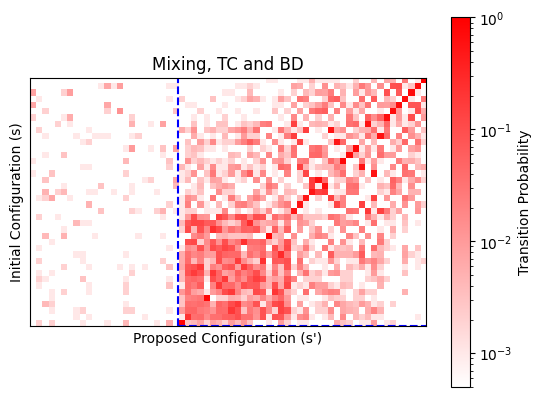

 --------------------- 
 


In [56]:

    
    
TC_gamma_ratio = 0.7#(0.7,0.9)
BD_gamma_ratio = 0.7#(0.05,0.2)


title = "Mixing, TC and BD"
titles.append(title)
Qsamp = Sampler(cardinality, method="quantum",dimension = 4,  verbose = True, qargs = {"gamma_ratios":[TC_gamma_ratio,BD_gamma_ratio], "t":t})#{"gammas":[0.98, 0.005, 0.015], "t":t})
analyse_output_bitstrings(Qsamp, repeats = repeats,title = title, plot_grid = True, plot_cumulative = False)



Notice how now, most proposals are of similar energy to their initial configuration. Of course, the probability of proposing the same state that you started in is higher